# FIFA 20 Player Stats analysis

Kaggle Dataset: https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset

In this notebook, some Exploratory Data Analysis and Machine Learning models applied over the FIFA datasets. Different analysis and techniques are performed, namely:
- Best team from a specific nationality
- Best young players, analysis of relevance of the players attributes
- Prediction of best position for a specific player
- Implementation of a Genetic Algorithm for finding the best set of players to buy under a given budget, considering different criteria, as, for example, the player age



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


## Load Data

In [3]:
#load data

def load_data(name):
    df = pd.read_csv(name + '.csv')
    df.dob=pd.to_datetime(df.dob)
    
    return df

fifa_15 = load_data('players_15')
fifa_16 = load_data('players_16')
fifa_17 = load_data('players_17')
fifa_18 = load_data('players_18')
fifa_19 = load_data('players_19')
fifa_20 = load_data('players_20')



## FIFA 20 - EDA

In [4]:
fifa_20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


## NaN Analysis

In [5]:
nan_columns = fifa_20.isnull().sum() > 0
nan_columns

sofifa_id     False
player_url    False
short_name    False
long_name     False
age           False
              ...  
lb             True
lcb            True
cb             True
rcb            True
rb             True
Length: 104, dtype: bool

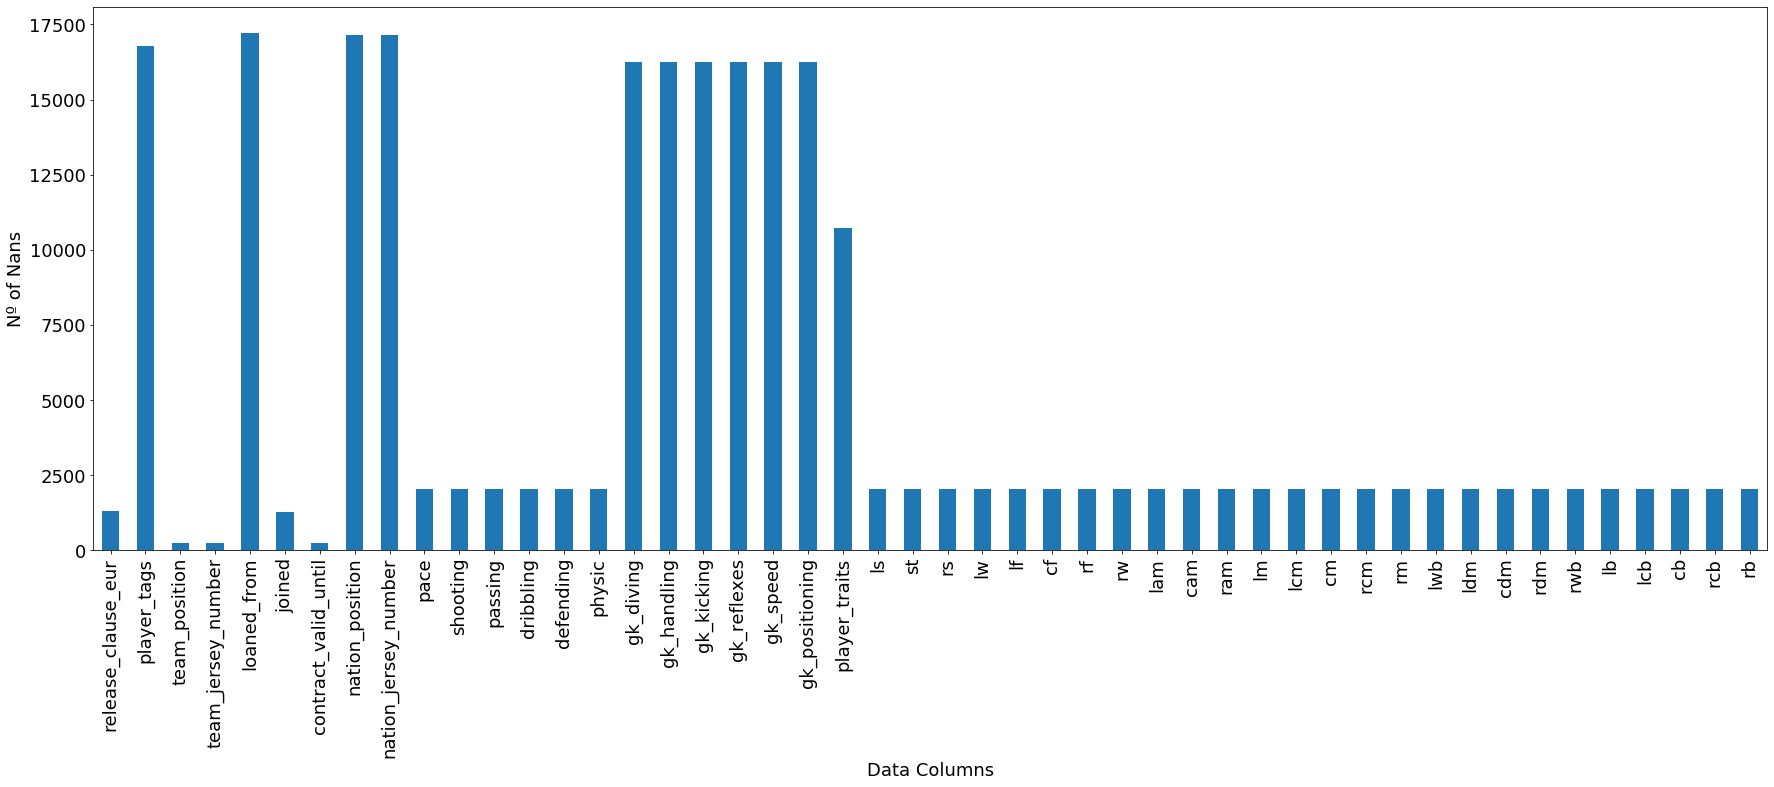

In [6]:
#Plot number of Nans in each column

nan_columns = fifa_20.isnull().sum() > 0
fifa_20.isnull().sum()[nan_columns].plot.bar(figsize = (30, 10))

plt.xlabel('Data Columns', fontsize=18), plt.xticks(fontsize=18)
plt.ylabel('Nº of Nans', fontsize=18), plt.yticks(fontsize=18)
plt.show()


Some columns have significant number of Nans, like *player_tags*, *nation_number* and *nation_jersey_number*. As they are not very relevant features, they may be removed

The GK attibutes also have a high percentage of Nans, this is due to the fact that the field players have Nan in the GK attibutes, therefore they will not be eliminated.

Also, there are columns like *pace*, *shooting*, *ls*, *st* that have a regular number of Nans (around 2000 players). After analysing the data, we can observe that these players correspond to GK. Hence, as these columns are not important, based on their field position, these columns are Nan, as shown below.

In [7]:
print('Players Position:', fifa_20[fifa_20['rb'].isnull()]['player_positions'].unique())

Players Position: ['GK']


Creation of some useful fields

In [8]:

def create_main_position(data):
        data.loc[:, 'main_position'] = data['player_positions'].apply(lambda x: x.split(',')[0])


create_main_position(fifa_15)
create_main_position(fifa_16)
create_main_position(fifa_17)
create_main_position(fifa_18)
create_main_position(fifa_19)
create_main_position(fifa_20)

## Best team from a specific Nationality

Given a specific Country and Tactic

In [22]:
tactic_433 = {
        'name': "433",
        'positions': ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW']
        }
    
tactic_442 = {
        'name': "442",
        'positions': ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'CDM', 'RM', 'ST', 'ST']
        }
    
tactic_352 = {
        'name': "352",
        'positions': ['GK', 'LWB', 'CB', 'RWB', 'LM', 'CDM', 'CAM', 'CM', 'RM', 'LW', 'RW']
        }


def get_best_team(data, nationality, chosen_tactic):

    best_team = []

    print("\nBest Team using tactic {} of {}:\n{}".format(chosen_tactic['name'], nationality, '='*35))

    for i in chosen_tactic['positions']:
        potential_players = data[(data['nationality'] == nationality) 
                                    & (data['player_positions'].str.contains(i))
                                   ].sort_values(['overall'], ascending=False)

        ind = 0
        while potential_players.iloc[ind].short_name in best_team:
            ind +=1

        best_team.append(potential_players.iloc[ind].short_name)
        print(i + ':', potential_players.iloc[ind].short_name + ' (' + str(potential_players.iloc[ind].overall) + ')')


#Examples

get_best_team(fifa_20, 'Portugal', tactic_433)

get_best_team(fifa_18, 'Spain', tactic_442)

get_best_team(fifa_20, 'Germany', tactic_352)





Best Team using tactic 433 of Portugal:
GK: A. Lopes (85)
LB: R. Guerreiro (81)
CB: Pepe (84)
CB: José Fonte (81)
RB: João Cancelo (84)
LM: Gonçalo Guedes (83)
CDM: William Carvalho (83)
RM: Pizzi (84)
LW: Cristiano Ronaldo (93)
ST: João Félix (80)
RW: Bernardo Silva (87)

Best Team using tactic 442 of Spain:
GK: De Gea (90)
LB: Azpilicueta (85)
CB: Sergio Ramos (90)
CB: Piqué (87)
RB: Carvajal (84)
LM: David Silva (87)
CDM: Thiago (88)
CDM: Javi Martínez (86)
RM: Isco (86)
ST: Diego Costa (86)
ST: Aduriz (84)

Best Team using tactic 352 of Germany:
GK: M. ter Stegen (90)
LWB: N. Schulz (82)
CB: M. Hummels (87)
RWB: D. da Costa (79)
LM: M. Reus (88)
CDM: J. Kimmich (86)
CAM: T. Müller (86)
CM: T. Kroos (88)
RM: J. Brandt (84)
LW: L. Sané (86)
RW: M. Özil (84)


## Young Players with highest potential


Difference between *current overall* and *potential overall* will be used

In [10]:

def get_best_talents(data, initial_overall=80):
    
    data['overall_diff'] = data.potential - data.overall
    
    data.sort_values(['overall_diff'], ascending = False, inplace = True)
    
    display(data.loc[data.overall >= initial_overall, ['short_name', 'age', 'nationality', 'club', 'player_positions', 'overall', 'potential']].head(10))


print("\n{} Wonderkids {}\n".format('='*30, '='*30))
#wonderkids
get_best_talents(fifa_17.copy(), 50)

print("\n\n{} Promising Players {}\n".format('='*25, '='*25))
#promising players
get_best_talents(fifa_15.copy(), 80)

print("\n\n{} Special Players {}\n".format('='*25, '='*25))
#future world star players
get_best_talents(fifa_20.copy(), 85)


============================== Wonderkids ==============================



,short_name,age,nationality,club,player_positions,overall,potential
14519,M. Edwards,17,England,Tottenham Hotspur,"CAM, RW",58,84
16481,A. Aktas,16,France,FC Sochaux-Montbéliard,CAM,52,78
16677,M. Bech Sørensen,17,Denmark,AC Horsens,LB,51,76
16482,P. Olszewski,17,Poland,Jagiellonia Białystok,RB,52,77
16796,J. Turner,17,England,Bolton Wanderers,GK,50,74
16483,D. Baur,17,Scotland,Heart of Midlothian,CB,52,75
16265,S. Pedersen,17,Norway,Stabæk Fotball,ST,53,76
16485,L. Burt,17,Scotland,Rangers FC,CAM,52,75
15714,M. Maolida,17,France,Olympique Lyonnais,ST,55,78
16266,J. Sbarra,17,England,Burton Albion,ST,53,76




========================= Promising Players =========================



,short_name,age,nationality,club,player_positions,overall,potential
207,S. El Shaarawy,21,Italy,Milan,LW,80,87
153,A. Laporte,20,France,Athletic Club de Bilbao,"CB, LB",81,88
152,R. Varane,21,France,Real Madrid,CB,81,88
151,S. Feghouli,24,Algeria,Valencia CF,"RM, RW",81,88
102,A. Griezmann,23,France,Atlético Madrid,"LW, LM",82,88
101,M. ter Stegen,22,Germany,FC Barcelona,GK,82,88
100,C. Eriksen,22,Denmark,Tottenham Hotspur,"CAM, LM",82,88
31,M. Götze,22,Germany,FC Bayern München,"CAM, CF, CM, RM",85,91
18,J. Rodríguez,22,Colombia,Real Madrid,"CAM, RW",86,92
63,P. Pogba,21,France,Juventus,"CM, CAM",83,89




========================= Special Players =========================



,short_name,age,nationality,club,player_positions,overall,potential
73,M. de Ligt,19,Netherlands,Juventus,CB,85,93
74,G. Donnarumma,20,Italy,Milan,GK,85,92
75,F. de Jong,22,Netherlands,FC Barcelona,"CM, CDM",85,91
55,L. Sané,23,Germany,Manchester City,LW,86,92
10,K. Mbappé,20,France,Paris Saint-Germain,"ST, RW",89,95
76,R. Varane,26,France,Real Madrid,CB,85,90
77,N. Süle,23,Germany,FC Bayern München,CB,85,90
78,S. Milinković-Savić,24,Serbia,Lazio,"CM, CAM",85,90
79,Rodri,23,Spain,Manchester City,"CDM, CM",85,90
56,Marquinhos,25,Brazil,Paris Saint-Germain,"CB, CDM",86,90


Promising players evolution

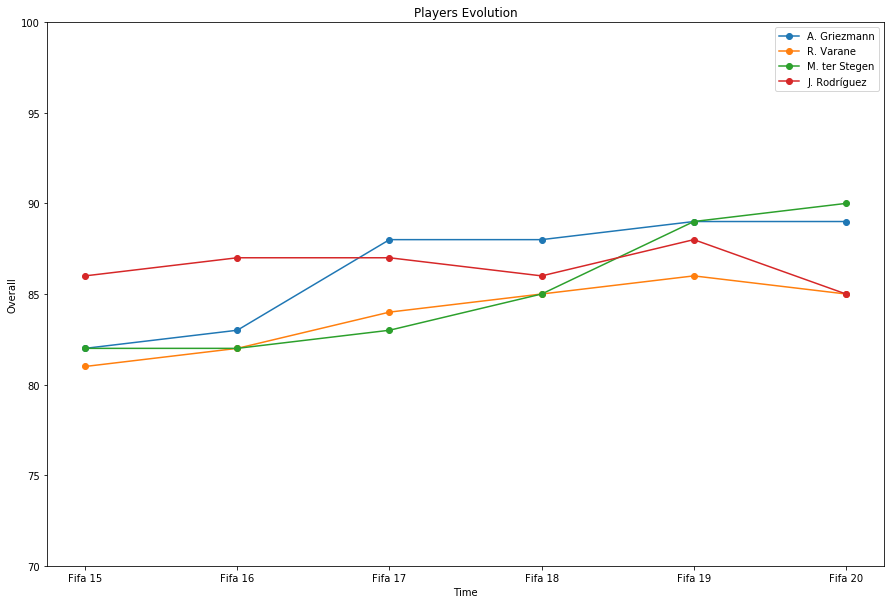

In [11]:
def player_evolution(all_data, names):
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    for n in names:
        overalls = []
        
        for d in all_data:
            player_overall = d.loc[d['short_name'] == n, 'overall']
            overalls.append(player_overall.iloc[0])

        plt.plot(overalls, 'o-', label=n)

    plt.ylim([70, 100])
    plt.ylabel('Overall')
    plt.xlabel('Time')
    plt.legend()
    
    plt.title('Players Evolution')
    
    ax.set_xticklabels(['_', 'Fifa 15', 'Fifa 16', 'Fifa 17', 'Fifa 18', 'Fifa 19', 'Fifa 20'])

    
    plt.show()
        
player_evolution([fifa_15, fifa_16, fifa_17, fifa_18, fifa_19, fifa_20], ['A. Griezmann', 'R. Varane', 'M. ter Stegen', 'J. Rodríguez'])

## Teams with higher potential


/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  import sys


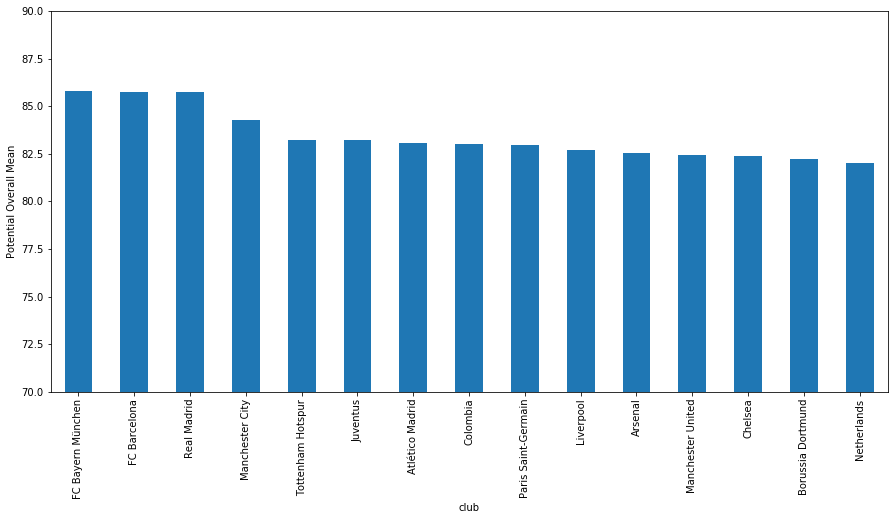

In [12]:
def potential_team(data):
    #data = data[~(data['team_position'].isin(['RES', 'SUB']))]
    
    potential_data = data.groupby('club')['potential'].mean().sort_values(ascending = False)[:15]
    
    plt.figure(figsize = (15, 7))
    potential_data.plot('bar')
    plt.ylim(70, 90)
    plt.ylabel('Potential Overall Mean')
    plt.show()
    
potential_team(fifa_20.copy())

On the barplot above, is possible to see the teams with highest potential, in terms of players future overall

## Analysis of Club Value vs Players Overall

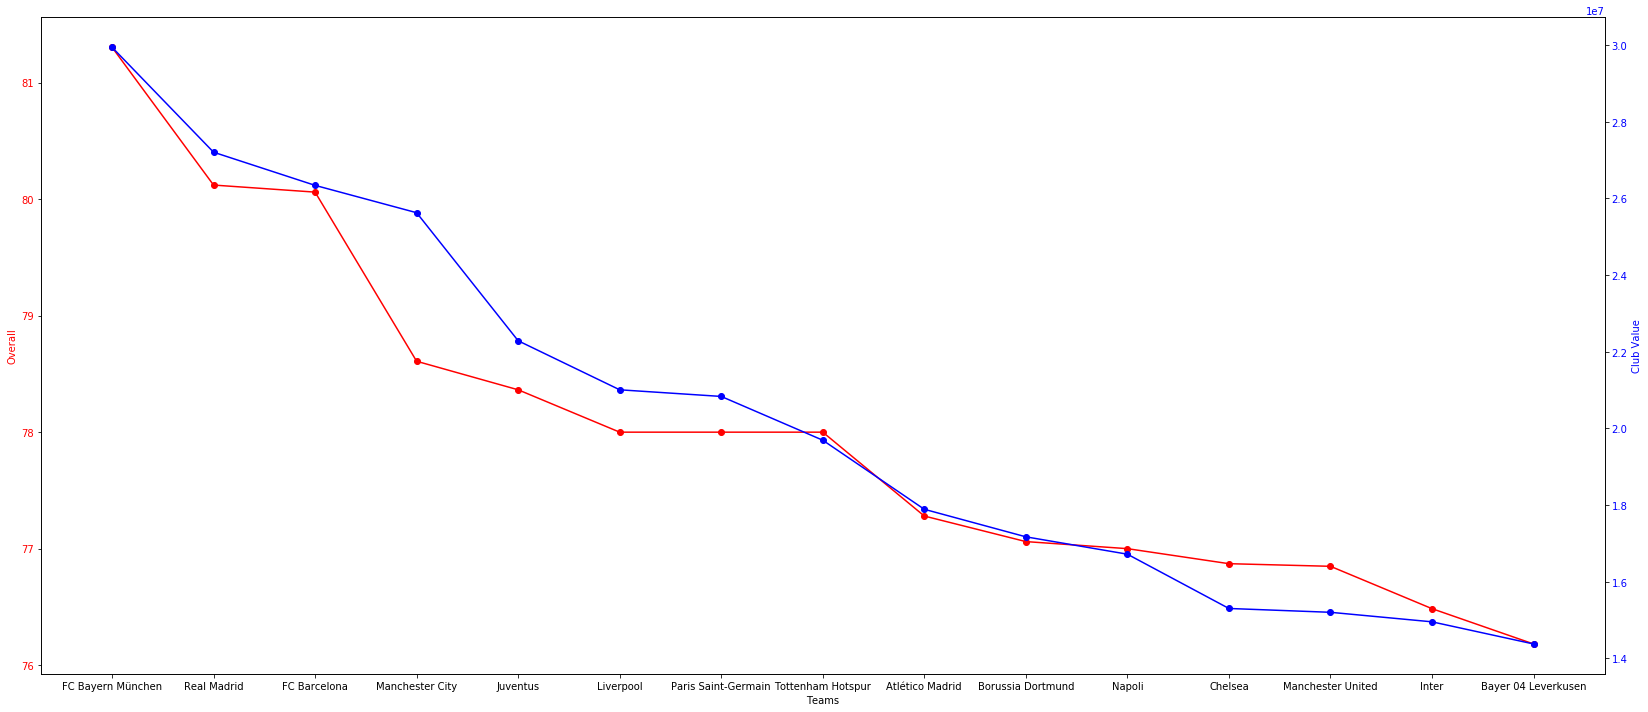

In [13]:

def overall_vs_value(data):
    
    best_overall = data.groupby('club')['overall'].mean().sort_values(ascending = False)[:15]
    best_value = data.groupby('club')['value_eur'].mean().sort_values(ascending = False)[:15]
    
    
    fig, ax1 = plt.subplots(figsize = (23, 10))

    color = 'red'
    ax1.set_xlabel('Teams')
    ax1.set_ylabel('Overall', color=color)
    ax1.plot(best_overall, 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'blue'
    ax2.set_ylabel('Club Value', color=color)  # we already handled the x-label with ax1
    ax2.plot(best_value, 'o-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


overall_vs_value(fifa_20.copy())

In this plot, we can see the teams with highest overall, in average, (red line) versus the club value (sum of all players value). In a general analysis, we can observe that the teams with the highest average overall are the ones with a higher squad value.

Nevertheless, looking in detail, we an see that clubs like 'Manchester City', 'Juventus', 'Liverpool' ans 'PSG' have a lower Overall than the expected. Taking the Club Value as reference, these clubs have a overall below the squad value (using the graph scaling), these means that there may be players overrated, in terms of their value, or a significant discrepancy in the players overall. Opponsigly, teams like 'Chelsea', 'Manchester United' and 'Inter' have players with greater overall than the expected, comparing to the Club Value line.

## Analysis of the importance of the different players attributes

In [14]:
def stats_players(data):
    
    pos_dict = {
        'GK': 'GK',
        'RW': 'ATA',
        'ST': 'ATA',
        'LW': 'ATA',
        'CAM': 'MED',
        'CB': 'DEF',
        'CM': 'MED',
        'CDM': 'MED',
        'CF': 'ATA',
        'LB': 'DEF',
        'RB': 'DEF',
        'RM': 'MED',
        'LM': 'MED',
        'LWB': 'DEF',
        'RWB': 'DEF'
    }
    
    data['general_position'] = data['main_position'].map(pos_dict)
    
    #use only the stats/attributes columns
    data = data.iloc[:, np.append([2, 14, -2, -1], np.arange(31, len(data.columns) - 28))]
    
    data.drop(['gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits'], axis = 1, inplace = True)
    
    data.fillna(0, inplace = True)
    
    return data
    
    
    
stats_data = stats_players(fifa_20.copy())

In [15]:
stats_data.head()

,short_name,player_positions,main_position,general_position,pace,shooting,passing,dribbling,defending,physic,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,"RW, CF, ST",RW,ATA,87.0,92.0,92.0,96.0,39.0,66.0,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,"ST, LW",ST,ATA,90.0,93.0,82.0,89.0,35.0,78.0,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,"LW, CAM",LW,ATA,91.0,85.0,87.0,95.0,32.0,58.0,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,GK,GK,GK,0.0,0.0,0.0,0.0,0.0,0.0,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,"LW, CF",LW,ATA,91.0,83.0,86.0,94.0,35.0,66.0,...,88,91,34,27,22,11,12,6,8,8


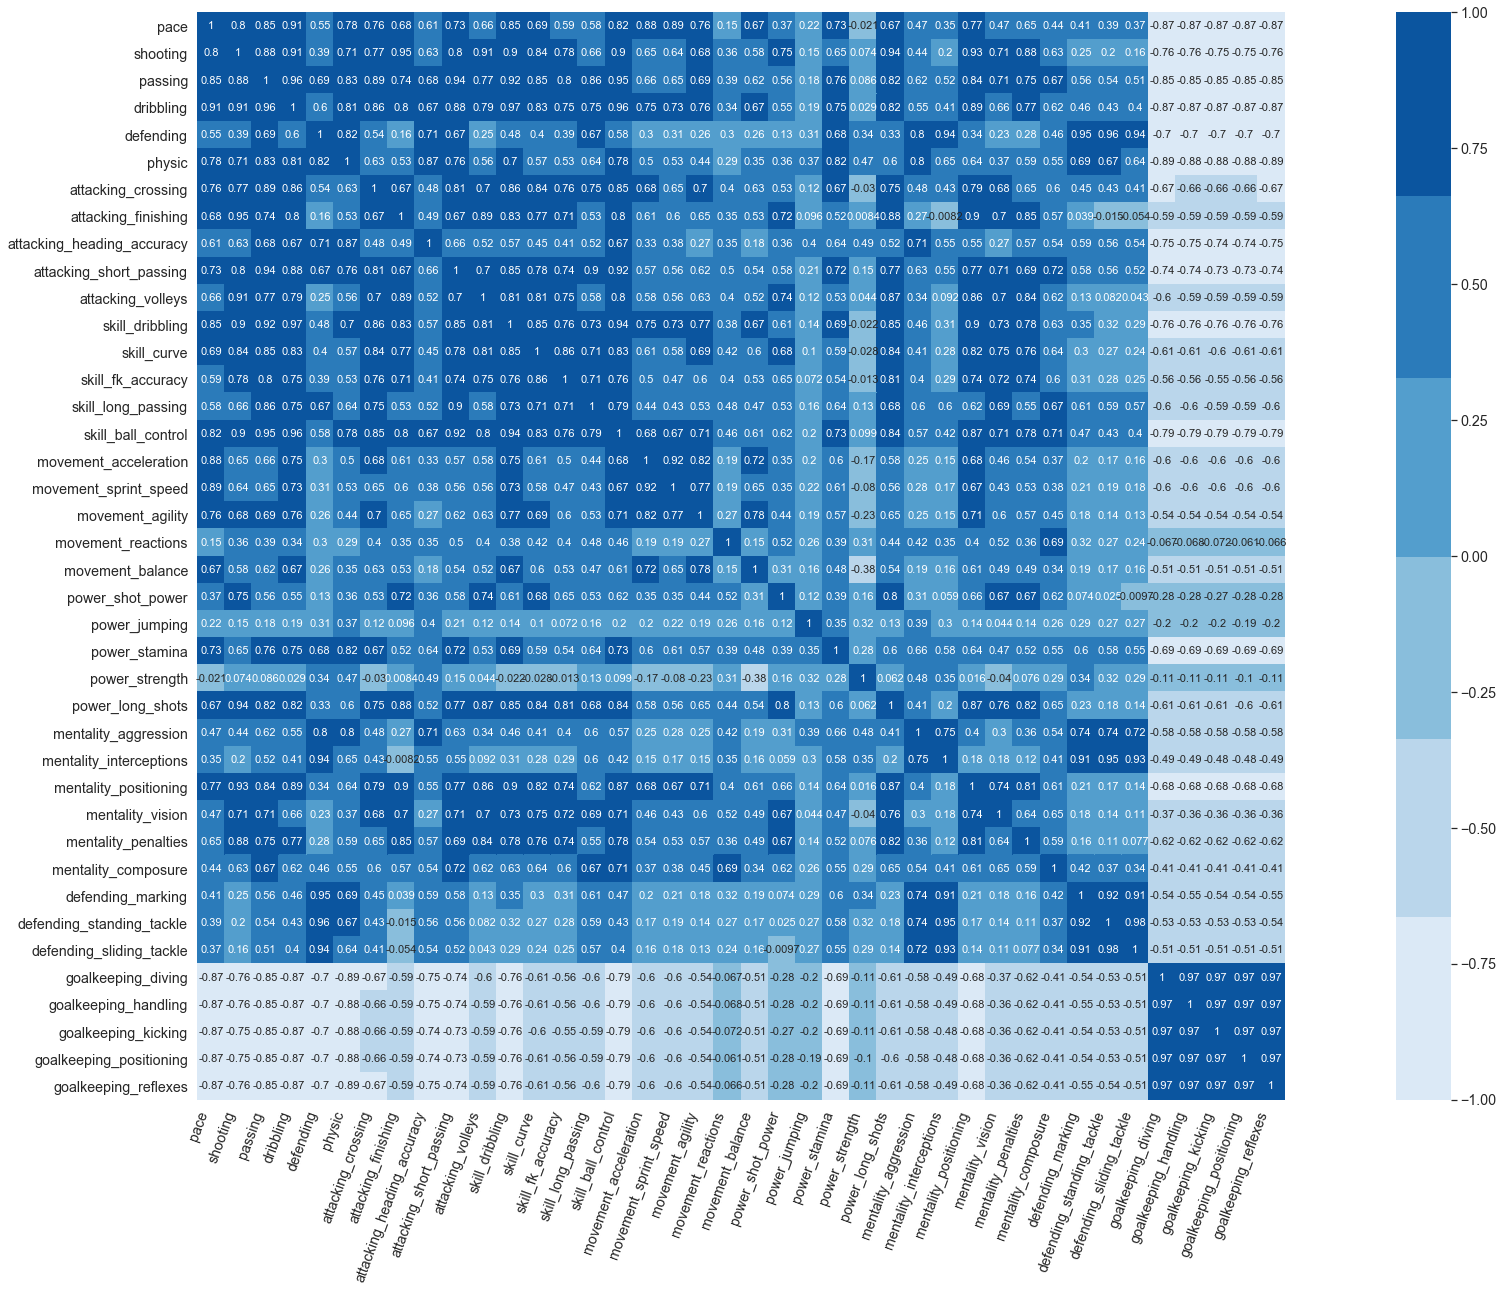

In [16]:
def plot_correlation(df):
    plt.figure(figsize=(40,20))

    sns.set(font_scale=1.3)

    ax = sns.heatmap(
        df, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.color_palette("Blues"),
        square=True,
        annot=True, annot_kws={"size": 11}
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=70,
        horizontalalignment='right'
    );

    plt.show()

plot_correlation(stats_data.iloc[:, 4:].corr())


By analysing correlations between the different attributes, some conclusions can be made:
- There is a **high positive** correlation between the *skill* attributes and *attacking* attributes
- There is a **positive** correlation between the *defending* and *physic* attributes, and a negative correlation between these attibutes and the *skill* attibutes
- There is a **positive** correlation between *skill* attributes and *mentality* attributes.
- Also, as expected, there is **very high correlation** between the GK attributes

Through general knowledge, these relationships between attributes were already expected, and are confirmed by the FIFA data


### Attributes that better represent the position of **Defender**

A binary classification is used to extract the most relevant features, using a Logistic Regression

In [17]:

def main_attributes_position(data, target_position = 'DEF'):
    
    data = data.iloc[0:5000, :]
    data['target'] = [1 if x == target_position else 0 for x in data['general_position']]
    
    data = data.drop(['short_name', 'player_positions', 'main_position', 'general_position'], axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis = 1), data['target'], test_size=0.2, random_state=20)
    
    feature_names = np.array(X_train.columns.values)
    
    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)
    
    n_feat = 5
    
    pos_inds = log_model.coef_[0].argsort()[-n_feat:][::-1]
    neg_inds = log_model.coef_[0].argsort()[:n_feat]
    
    print('Attributes with most Positive Impact:\n', feature_names[pos_inds])
    print('\nAttributes with most Negative Impact:\n', feature_names[neg_inds])    
    
    
    #Test
    y_pred = log_model.predict(X_test)
    print("\n\nTest Accuracy: ", round(accuracy_score(y_test, y_pred), 2))
    print("Test Recall: ", round(recall_score(y_test, y_pred), 2))
    


main_attributes_position(stats_data.copy(), 'DEF')

Attributes with most Positive Impact:
 ['defending' 'passing' 'physic' 'defending_sliding_tackle'
 'movement_reactions']

Attributes with most Negative Impact:
 ['attacking_short_passing' 'mentality_vision' 'dribbling'
 'skill_long_passing' 'mentality_aggression']


Test Accuracy:  0.96
Test Recall:  0.95


/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Based on the obtained results, we can see that, for a **Defender**, the most representative attibutes, with positive impact (that is, are higher than the average player) are :
- [*defending*, *passing*, *physic*, *defending_sliding_tackle*, *movement_reactions*]

The attibutes with negative impact (meaning the lesser the values, most probably it is a Defender) are:
- [*attacking_short_passing*, *mentality_vision*, *dribbling*, *skill_long_passing*, *mentality_aggression*]

### Visualization of relationship between the different positions

By applying PCA to all players attibutes, a spread of the reduced attibutes is obtained


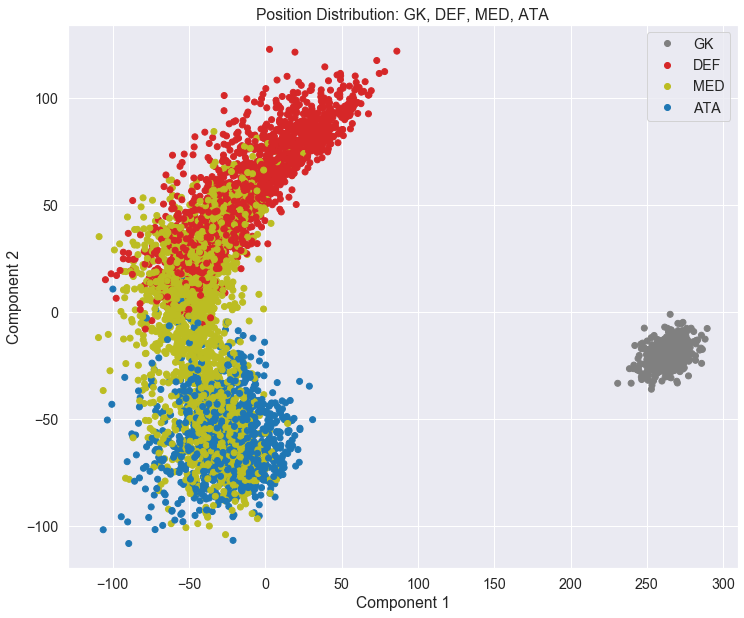

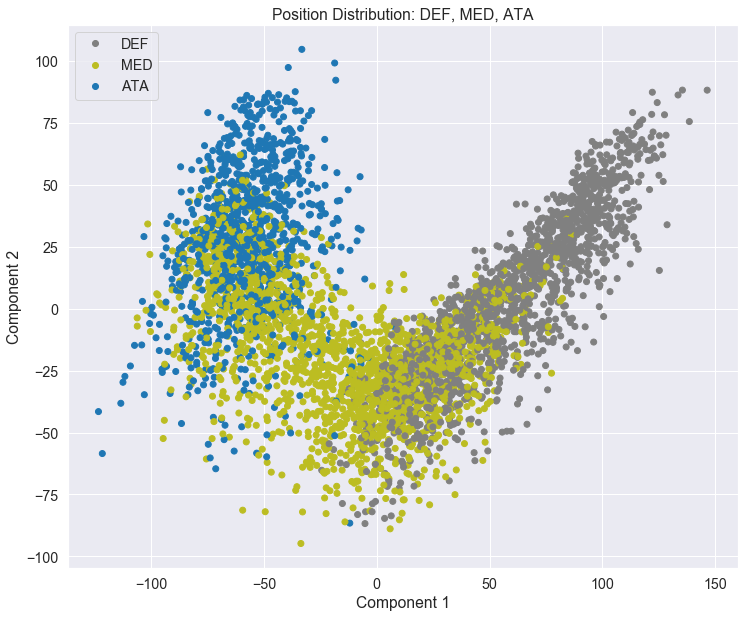

In [18]:

def positions_distribution(data, target_positions):
    
    data = data.iloc[0:5000, :]
    
    data = data[data['general_position'].isin(target_positions)]
    
    
    pos_dict = {
        'GK': 0,
        'DEF': 1,
        'MED': 2,
        'ATA': 3
    }
    
    data = data.sample(frac=1)
    target = data['general_position'].map(pos_dict).values
    
    data_attributes = data.drop(['short_name', 'player_positions', 'main_position', 'general_position'], axis = 1)
    
    pca_model = PCA(n_components=2)
    reduced_data = pca_model.fit_transform(data_attributes)
    
    colors = ListedColormap(['grey', 'tab:red', 'tab:olive', 'tab:blue'])
    
    fig, ax = plt.subplots(figsize=(12, 10))
    #ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=target, cmap=colors)
    
    plt.legend(handles=scatter.legend_elements()[0], labels=target_positions)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Position Distribution: ' + ', '.join(target_positions))
    
    plt.show()
    
    
positions_distribution(stats_data.copy(), ['GK', 'DEF', 'MED', 'ATA'])
positions_distribution(stats_data.copy(), ['DEF', 'MED', 'ATA'])
    

We can clearly see, in the first Figure, a distinction of *GK* position (grey cluster). Regarding the remaning positions, we can see that there is a distinction between the Attackers and Defenders, and Midfielders are in between Attackers and Defenders. This would be expected, as besides the Midfielders are in the central position of the field, there are more defensive Midfielders (CDM) and more attacking Midfielders (CAM)

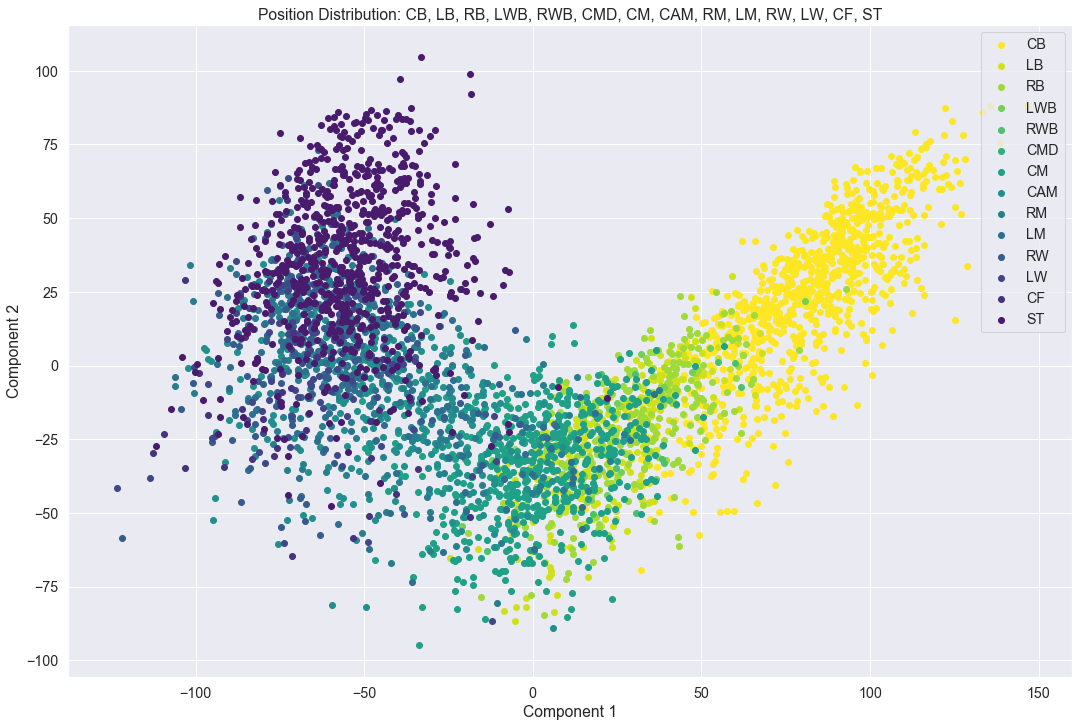

In [19]:
def all_positions_distribution(data):
    
    data = data.iloc[0:5000, :]
    data = data[data['main_position'] != 'GK']
    
    pos_dict = {}
    
    l = ['CB', 'LB', 'RB', 'LWB', 'RWB', 'CMD', 'CM', 'CAM', 'RM', 'LM', 'RW', 'LW', 'CF', 'ST']

    for i, p in enumerate(l):
        pos_dict[p] = i
    
    data = data.sample(frac=1)
    target = data['main_position'].map(pos_dict).values
    
    data_attributes = data.drop(['short_name', 'player_positions', 'main_position', 'general_position'], axis = 1)
    
    pca_model = PCA(n_components=2)
    reduced_data = pca_model.fit_transform(data_attributes)
    
    colors = plt.get_cmap('viridis_r')
    
    fig = plt.figure(figsize=(18, 12))
    
    
    for i, p in enumerate(l):
        c = colors(i/len(l))
        inds = [j for j, x in enumerate(data['main_position']) if x == p]
        plt.scatter(reduced_data[inds, 0], reduced_data[inds, 1], label=p, color=c)
    
    
    plt.legend(loc='upper right')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Position Distribution: ' + ', '.join(l))
    
    plt.show()
    
all_positions_distribution(stats_data.copy())

By analysing the distribution of all players positions, we can clearly see a continuous transition between the different positions, from the more defensive (yellow) to the more attacking (purple). For example, we can see that the defensive midfielder (CMD) is the position (from Midfielders and Attackers) closer to the defensive positions.

Therefore we can conclude that the players attributes change continuously, from the more defensive to the more attacking positions

### Predict Player position

KNN will be used to predict a Player main position, based on all attibutes

Confusion Matrix:


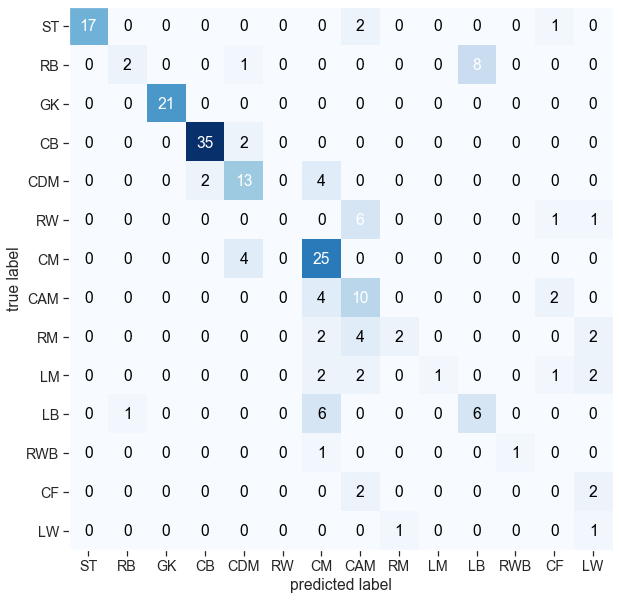


5 Examples: 
Name: N. Petersen
Prediction: ST
 True Pos: ST

Name: Ricardo Pereira
Prediction: LB
 True Pos: RB

Name: L. Karius
Prediction: GK
 True Pos: GK

Name: E. Schetino
Prediction: CB
 True Pos: CB

Name: L. Torreira
Prediction: CDM
 True Pos: CDM



In [20]:

def best_position(data):
    
    data = data.iloc[0:1000, :]

    X_train, X_test, y_train, y_test = train_test_split(data.drop(['main_position'], axis = 1), data['main_position'], test_size=0.2, random_state=8)
    
    n_test = 5

    X_train = X_train.drop(['short_name', 'player_positions', 'general_position'], axis = 1)

    test_names = X_test['short_name'].values
    X_test = X_test.drop(['short_name', 'player_positions', 'general_position'], axis = 1)
    
    
    k = 5
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    
    #Test
    y_pred = knn_model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    
    print("Confusion Matrix:")
    fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(10, 10))
    x = np.arange(0, 14)
    my_xticks = y_test.unique()
    plt.xticks(x, my_xticks)
    plt.yticks(x, my_xticks)
    plt.show()
    
    print("\n{} Examples: ".format(n_test))
    for i in range(n_test):
        pred_pos = knn_model.predict(X_test.iloc[[i]])[0]
        
        print('Name: {}\nPrediction: {}\n True Pos: {}\n'.format(test_names[i], pred_pos, y_test.iloc[i]))
    
    
    
best_position(stats_data.copy())



As we can see, by analysing the players attributes is possible to predict their positions with significant accuracy. 
The positions easier to identify, by looking to the Confusion Matrix, are the GK, CB and ST. Opponsingly, the positions with higher uncertanty in their prediction are LB/RB and also all positions around CM.

These conclusions make sense as, from the attibutes point of view, LB and RB are very similar, also as the CM position is central in the field it may be mixed up with the surrounding positions.

From a different perspective, using this model, is possible to predict the position most suitable to a given player, based on his attributes

## Get best set of players given a specific budget

An Evolutionary Algorithm is going to be used to identify the best set of players for specific positions, without trespassing a given budget. Also the players age will be taken in consideration, as yourger players are preferred, due to their potential.

For simplicity reasons, we are going to assume that players are sold at a price 20% greater than their value.


Iteration  0 : Average Score: 66138095.927 Best so far: 35528013.8
Iteration  5 : Average Score: 29623215.34 Best so far: 4640014.8
Iteration  10 : Average Score: 7171215.133 Best so far: 4640014.8
Iteration  15 : Average Score: 4356548.22 Best so far: 1576015.6
Iteration  20 : Average Score: 2332815.58 Best so far: 1576015.6
Iteration  25 : Average Score: 1423215.867 Best so far: 1048017.0
Iteration  30 : Average Score: 999376.513 Best so far: 640016.4
Iteration  35 : Average Score: 722895.867 Best so far: 640016.4
Iteration  40 : Average Score: 640016.4 Best so far: 640016.4
Iteration  45 : Average Score: 640016.4 Best so far: 640016.4
Iteration  50 : Average Score: 640016.4 Best so far: 640016.4
Iteration  55 : Average Score: 640016.4 Best so far: 640016.4
Iteration  60 : Average Score: 640016.4 Best so far: 640016.4
Iteration  65 : Average Score: 641936.34 Best so far: 640016.4
Iteration  70 : Average Score: 640016.4 Best so far: 640016.4
Iteration  75 : Average Score: 640016.4 Bes

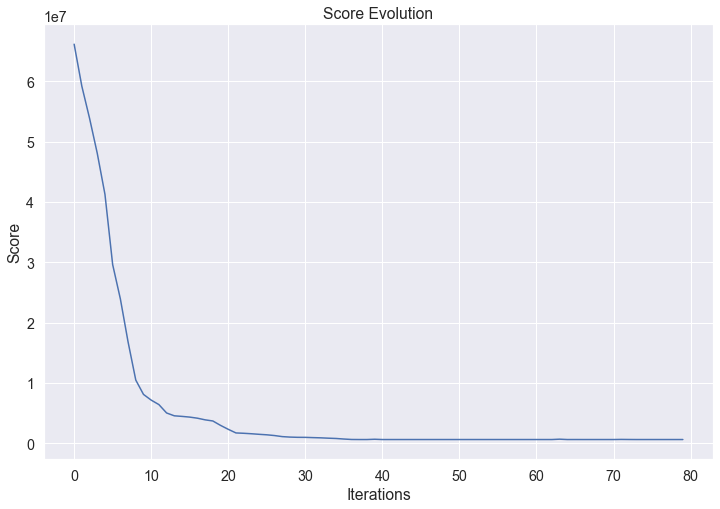

Best players for ['ST', 'CM', 'GK']:
T. Müller:
	Age: 29, Overall: 86
M. Ozdoev:
	Age: 26, Overall: 72
J. Rodríguez:
	Age: 27, Overall: 85

Max Budget:  100000000
Budget Used:  84000000


In [31]:


def init_population(data, n, positions_target):

    population = []
    for _ in range(n):
        indv = []
        for j in positions_target:
            p = data[data['main_position'] == j].sample(1)
            indv.append(p.iloc[0].short_name)
        population.append(indv)

    return population
    



#One point Crossover
def crossover(indv_1, indv_2):

    if random.random() < prob_crossover:

        pos = random.randint(0,len(indv_1))
        f1 = indv_1[:pos] + indv_2[pos:]
        f2 = indv_2[:pos] + indv_1[pos:]
        return [f1, f2]

    else:
        return [indv_1,indv_2]


def random_mutation(indv, positions, data):
    new_indv = indv.copy()

    for i in range(len(indv)):
        if  random.random() < prob_mutation:
            p = data[data['main_position'] == positions[i]].sample(1)

            new_indv[i] = p.iloc[0]['short_name']

    return new_indv


def evaluate_population(original_data, population, budget):
    alpha = 0.8
    beta = 0.2
    scores = []
    for indv in population:

        accumulated_value = 0
        ages = 0
        for i in indv:
            p = original_data[original_data['short_name'] == i]
            
            accumulated_value += p.iloc[0].value_eur + 0.2 * p.iloc[0].value_eur
            ages += p.iloc[0].age
        
        
        scores.append(round(alpha * np.abs(budget - accumulated_value) + beta * np.mean(ages), 2))

    return scores

def indv_value(indv, data):

    accumulated_value = 0
    for i in indv:
        p = data[data['short_name'] == i]
        accumulated_value += p.iloc[0].value_eur
        
    return accumulated_value

def argsort_list(seq):
    return [x for x,y in sorted(enumerate(seq), key = lambda x: x[1])]


def elitism(original_data, population, offspring, budget):
    
    scores_pop = evaluate_population(original_data, population, budget)
    scores_offs = evaluate_population(original_data, offspring, budget)
    
    comp_elite = int(len(population) * elitism_size)
    
    population = [population[ind] for ind in argsort_list(scores_pop)]
    offspring = [offspring[ind] for ind in argsort_list(scores_offs)]
    
    new_population = population[:comp_elite] + offspring[:len(population) - comp_elite]

    return new_population


def evolve(data, target_positions, budget):

    num_iters = 80

    scores = np.zeros(num_iters)
    best_indv = None
    best_score = float('+inf')

    population = init_population(data, n_pop, target_positions)

    #print("Initial Population: ", population)
    
    for it in range(num_iters):

        pool = population
        
        #Crossover
        parents = []
        for i in  range(0, n_pop - 1, 2):
            indiv_1= pool[i]
            indiv_2 = pool[i+1]
            parents.extend(crossover(indiv_1, indiv_2)) 
        
        #Mutation
        offspring = []
        for indv in parents:
            offspring.append(random_mutation(indv, target_positions, data))
        
        #Select the best inviduals: Elitism
        population = elitism(fifa_20, population, offspring, budget)
        pop_scores = evaluate_population(data, population, budget)
                
        for i in range(len(pop_scores)):

            if pop_scores[i] < best_score:
                best_indv = pop_scores[i]
                best_players = population[i]
                best_score = pop_scores[i]

            scores[it] = np.mean([pop_scores[s] for s in range(len(pop_scores))])

        if it % 5 == 0:
            print("Iteration ", it, ": Average Score:", round(scores[it], 3), "Best so far:", round(best_score, 3))

        
    plt.figure(figsize=(12, 8))
    plt.plot(scores)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.title('Score Evolution')
    plt.show()
    
    print('Best players for {}:'.format(target_positions))

    for i in best_players:
        p = data[data['short_name'] == i]
        print('{}:\n\tAge: {}, Overall: {}'.format(i, p.iloc[0].age, p.iloc[0].overall))
            
    print('\nMax Budget: ', budget)
    print('Budget Used: ', indv_value(best_players, data))


target_pos = ['ST', 'CM', 'GK']
b = 100000000
n_pop = 30
prob_mutation = 0.2
prob_crossover = 0.8
elitism_size = 0.6
evolve(fifa_20, target_pos, b)


As conclusion, we can see that over time the algorithm converges to an optimal solution, close to the perfect one. There is not only one perfect solution, as there are a lot of possible players combinations. Thus, different solutions can be obtained, closer to the optimal (which corresponds to the use of all available budget).

The EA are dependent on a good parameter tuning, therefore, this can be a possible path to explore in the future. Moreover, other possible improvement concerns the addition of more weights and conditions to our fitness function, besides players age and value.